In [106]:
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams["font.size"] = "10"

In [2]:
data    = pd.read_csv("test/ubuntu/individual-benchmarks-new.csv")
data_lg = pd.read_csv("test-lambda-groups/ubuntu/individual-benchmarks-new.csv")
data_pg = pd.read_csv("test-pg-lambda-groups/ubuntu/individual-benchmarks-new.csv")
data_r8 = pd.read_csv("test-r8/ubuntu/individual-benchmarks-new.csv")

In [3]:
data["transformation"] = "original"
data_lg["transformation"] = "pg_lambda_merging"
data_pg["transformation"] = "pg_shrinking_lambda_merging_optimisation"
data_r8["transformation"] = "r8_shrinking_optimisation"

In [4]:
df = pd.concat([data, data_lg, data_pg, data_r8], ignore_index=True)

In [5]:
def get_arity_from_benchmark(benchmark):
    benchmark = benchmark.replace("InstantiationsAnd", "")
    benchmark = benchmark.replace("test.MyBenchmark.emptyClosure", "")
    benchmark = benchmark.replace("Arguments3MillionCalls", "")
    try:
        arity = int(benchmark)
        return arity
    except Exception:
        return 0

In [6]:
def get_closure_size_from_benchmark(benchmark):
    benchmark = benchmark.replace("InstantiationsAnd", "")
    benchmark = benchmark.replace("test.MyBenchmark.closure", "")
    benchmark = benchmark.replace("FreeVariables3MillionCalls", "")
    benchmark = benchmark.replace("FreeVariables3MillionInstantiations", "")
    try:
        closure_size = int(benchmark)
        return closure_size
    except Exception as exc:
        return 0

In [7]:
def add_test_type(data):
    data["closure_test"] = data["benchmark"].apply(lambda val: val.startswith("test.MyBenchmark.closure") and "FreeVariables" in val)
    data["arity_test"] = data["benchmark"].apply(lambda val: val.startswith("test.MyBenchmark.emptyClosure") and "Arguments3Million" in val)
    data["instantiation_test"] = data["benchmark"].apply(lambda val: "Instantiations" in val)
    data["invocation_test"] = data["benchmark"].apply(lambda val: "Calls" in val)

In [8]:
def add_arity(data):
    data["arity"] = data["benchmark"].apply(get_arity_from_benchmark)

In [9]:
def add_closure_size(data):
    data["closure_size"] = data["benchmark"].apply(get_closure_size_from_benchmark)

In [10]:
add_test_type(df)
add_arity(df)
add_closure_size(df)

In [11]:
test_df = df.query("iteration_type == 'test'")

transformation
original                                    AxesSubplot(0.125,0.125;0.775x0.755)
pg_lambda_merging                           AxesSubplot(0.125,0.125;0.775x0.755)
pg_shrinking_lambda_merging_optimisation    AxesSubplot(0.125,0.125;0.775x0.755)
r8_shrinking_optimisation                   AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

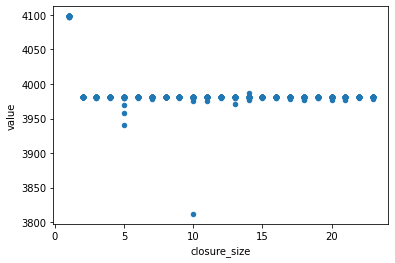

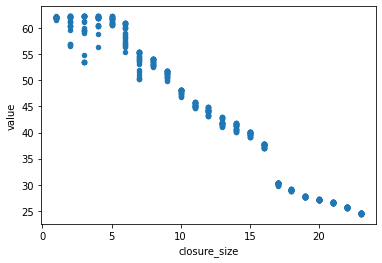

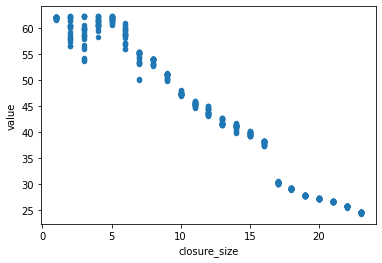

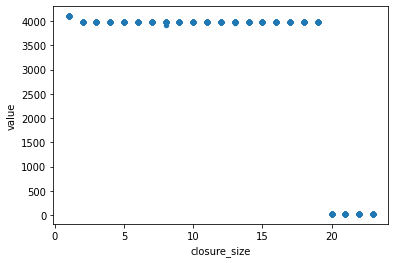

In [12]:
test_df.query("closure_test and invocation_test and not instantiation_test").groupby(by="transformation").plot.scatter(x="closure_size", y="value")

transformation
original                                    AxesSubplot(0.125,0.125;0.775x0.755)
pg_lambda_merging                           AxesSubplot(0.125,0.125;0.775x0.755)
pg_shrinking_lambda_merging_optimisation    AxesSubplot(0.125,0.125;0.775x0.755)
r8_shrinking_optimisation                   AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

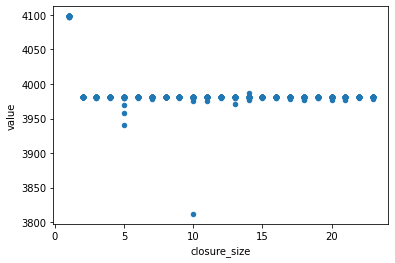

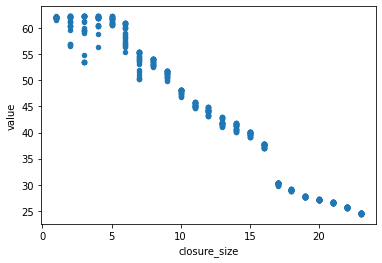

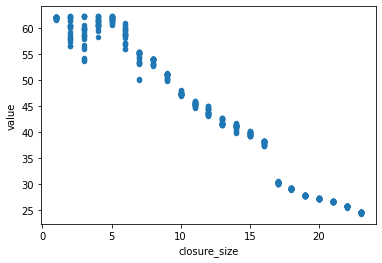

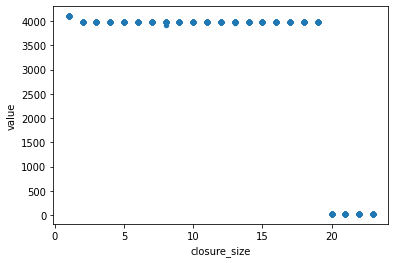

In [12]:
for transformation in ["original", "pg_lambda_merging", "pg_shrinking_lambda_merging_optimisation", "r8_shrinking_optimisation"]:
    print(transformation)
    ax = test_df.query(f"closure_test and invocation_test and not instantiation_test and transformation == '{transformation}'").plot.scatter(x="closure_size", y="value")
    ax.set_title(transformation)

In [120]:
name_to_file_name = {"original": "before-lambda-merging", "pg_lambda_merging": "after-lambda-merging", "pg_shrinking_lambda_merging_optimisation": "pg", "r8_shrinking_optimisation": "r8"}

In [121]:
def plot_performance_results(query, x_label, y_label, base_file_name, x_column, y_column="value", y_unit = "ops/s", round_dec=0):
    for transformation in ["original", "pg_lambda_merging", "pg_shrinking_lambda_merging_optimisation", "r8_shrinking_optimisation"]:
        value_aggs = test_df.query(f"{query} and transformation == '{transformation}'").groupby(by=x_column)[[y_column]].describe().reset_index()
        ax = value_aggs.plot.scatter(x=x_column, y=(y_column, "mean"), figsize=(5.5082/2, 5.5082/2))
        ax.errorbar(value_aggs[x_column], value_aggs[y_column]["mean"], yerr=value_aggs[y_column]["std"], fmt="o", ecolor="black", capsize=2)
        #ax.set_title(transformation.replace("_", " "))
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax.yaxis.set_major_formatter(lambda val, val2: f"{round(val) if round_dec == 0 else round(val, round_dec)} {y_unit}")
        #plt.scatter(value_aggs["closure_size"], value_aggs["value"]["50%"], color="red") #, yerr=("value", "std"))
        plt.savefig(f"figures/{base_file_name}-{name_to_file_name[transformation]}-nl.pdf", bbox_inches='tight')

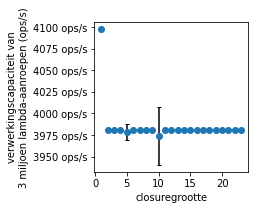

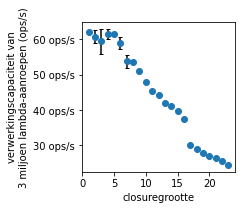

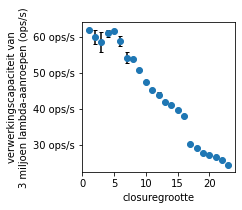

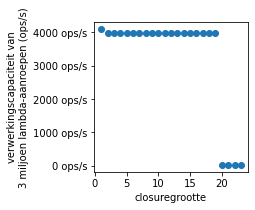

In [122]:
"""
for transformation in ["original", "pg_lambda_merging", "pg_shrinking_lambda_merging_optimisation", "r8_shrinking_optimisation"]:
    value_aggs = test_df.query(f"closure_test and invocation_test and not instantiation_test and transformation == '{transformation}'").groupby(by="closure_size")[["value"]].describe().reset_index()
    ax = value_aggs.plot.scatter(x="closure_size", y=("value", "mean")) #, yerr=("value", "std"))
    ax.errorbar(value_aggs["closure_size"], value_aggs["value"]["mean"], yerr=value_aggs["value"]["std"], fmt="o", ecolor="black", capsize=2)
    #ax.set_title(transformation.replace("_", " "))
    ax.set_xlabel("closuregrootte")
    ax.set_ylabel("verwerkingscapaciteit van\n3 miljoen lambda-aanroepen (ops/s)")
    ax.yaxis.set_major_formatter(lambda val, val2: f"{round(val)} ops/s")
    #plt.scatter(value_aggs["closure_size"], value_aggs["value"]["50%"], color="red") #, yerr=("value", "std"))
    plt.savefig(f"individual-performance-benchmark-results-closure-call-{transformation.replace('_', '-')}.pdf")
"""
plot_performance_results(query="closure_test and invocation_test and not instantiation_test", x_label="closuregrootte", y_label="verwerkingscapaciteit van\n3 miljoen lambda-aanroepen (ops/s)", base_file_name="average-throughput-invocation-closure", x_column="closure_size")

original
pg_lambda_merging
pg_shrinking_lambda_merging_optimisation
r8_shrinking_optimisation


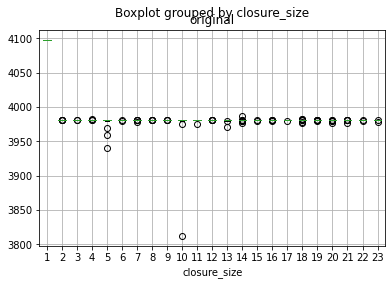

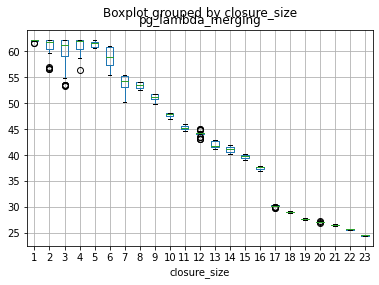

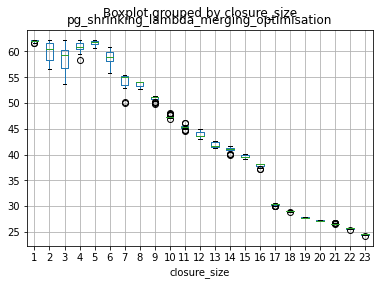

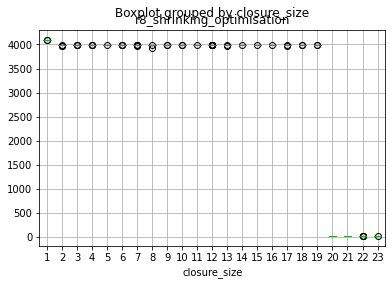

In [28]:
for transformation in ["original", "pg_lambda_merging", "pg_shrinking_lambda_merging_optimisation", "r8_shrinking_optimisation"]:
    print(transformation)
    ax = test_df.query(f"closure_test and invocation_test and not instantiation_test and transformation == '{transformation}' and iteration_type == 'test'").boxplot(by="closure_size", column="value")
    ax.set_title(transformation)

original
pg_lambda_merging
pg_shrinking_lambda_merging_optimisation
r8_shrinking_optimisation


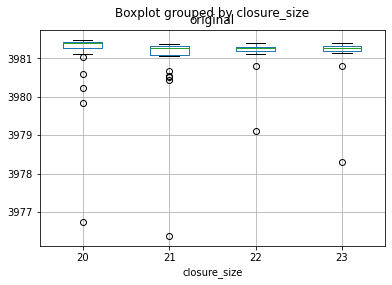

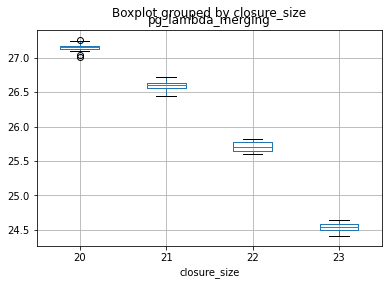

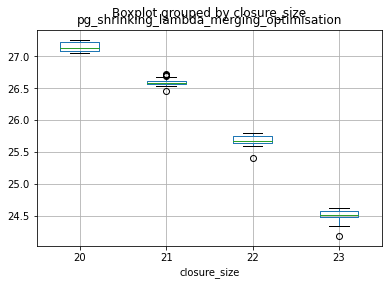

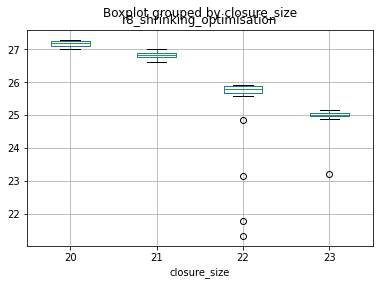

In [31]:
for transformation in ["original", "pg_lambda_merging", "pg_shrinking_lambda_merging_optimisation", "r8_shrinking_optimisation"]:
    print(transformation)
    ax = test_df.query(f"closure_test and invocation_test and not instantiation_test and transformation == '{transformation}' and iteration_type == 'test' and closure_size >= 20").boxplot(by="closure_size", column="value")
    ax.set_title(transformation)

original                                         AxesSubplot(0.1,0.559091;0.363636x0.340909)
pg_lambda_merging                           AxesSubplot(0.536364,0.559091;0.363636x0.340909)
pg_shrinking_lambda_merging_optimisation             AxesSubplot(0.1,0.15;0.363636x0.340909)
r8_shrinking_optimisation                       AxesSubplot(0.536364,0.15;0.363636x0.340909)
dtype: object

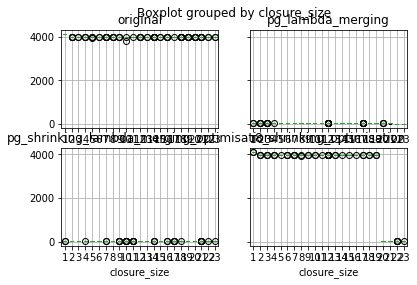

In [19]:

test_df.query("closure_test and invocation_test and not instantiation_test").groupby(by="transformation").boxplot(by="closure_size", column="value")
test_df.query("closure_test and invocation_test and not instantiation_test").groupby(by="transformation").boxplot(by="closure_size", column="value")
test_df.query("closure_test and invocation_test and not instantiation_test").groupby(by="transformation").boxplot(by="closure_size", column="value")
test_df.query("closure_test and invocation_test and not instantiation_test and transformation == 'r8_shrinking_optimisation'").groupby(by="transformation").boxplot(by="closure_size", column="value")

transformation
original                                    AxesSubplot(0.125,0.125;0.775x0.755)
pg_lambda_merging                           AxesSubplot(0.125,0.125;0.775x0.755)
pg_shrinking_lambda_merging_optimisation    AxesSubplot(0.125,0.125;0.775x0.755)
r8_shrinking_optimisation                   AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

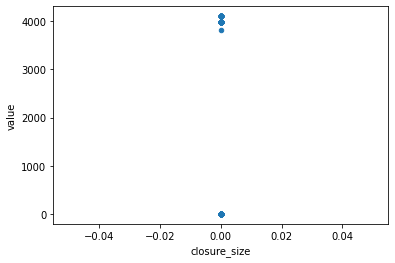

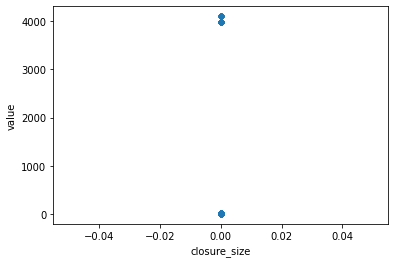

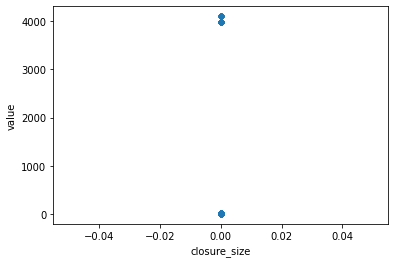

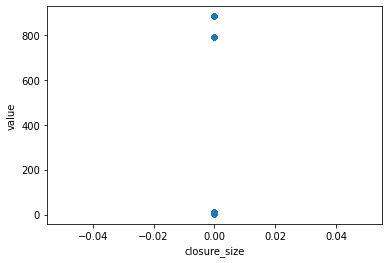

In [13]:
test_df.query("arity_test and invocation_test and not instantiation_test").groupby(by="transformation").plot.scatter(x="closure_size", y="value")

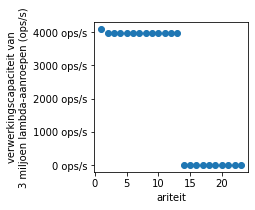

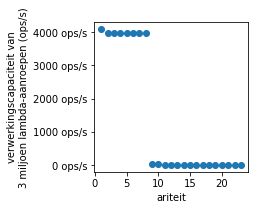

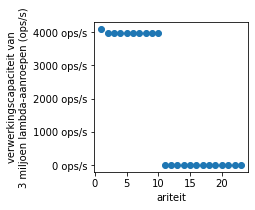

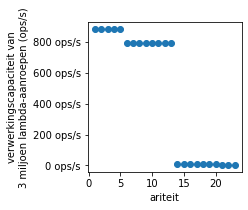

In [123]:
#test_df.query("arity_test and invocation_test and not instantiation_test").groupby(by="transformation").plot.scatter(x="arity", y="value")
plot_performance_results(query="arity_test and invocation_test and not instantiation_test", x_label="ariteit", y_label="verwerkingscapaciteit van\n3 miljoen lambda-aanroepen (ops/s)", base_file_name="average-throughput-invocation-arity", x_column="arity")

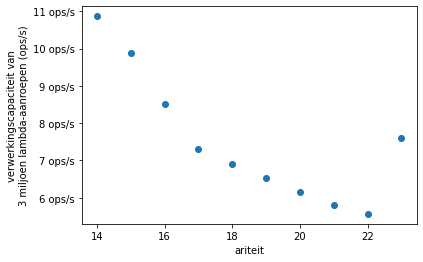

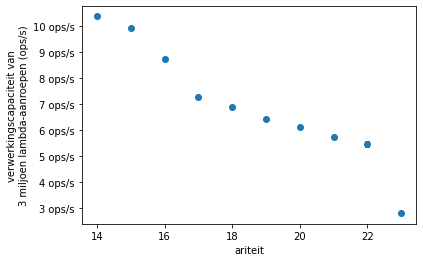

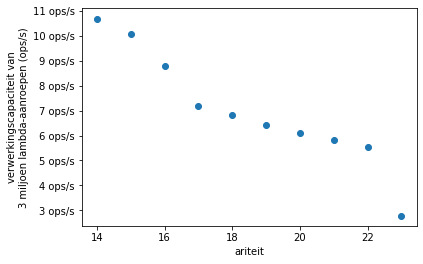

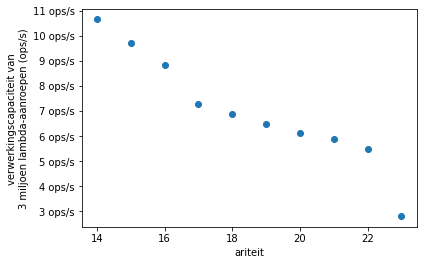

In [87]:
plot_performance_results(query="arity_test and invocation_test and not instantiation_test and arity > 13", x_label="ariteit", y_label="verwerkingscapaciteit van\n3 miljoen lambda-aanroepen (ops/s)", base_file_name="individual-performance-benchmark-results-arity-14+-call", x_column="arity")

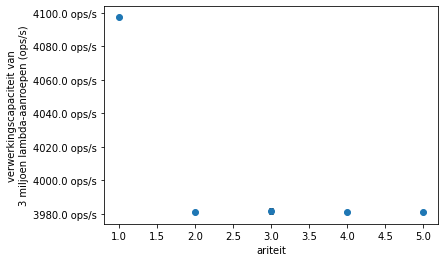

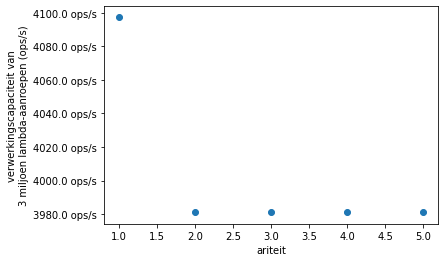

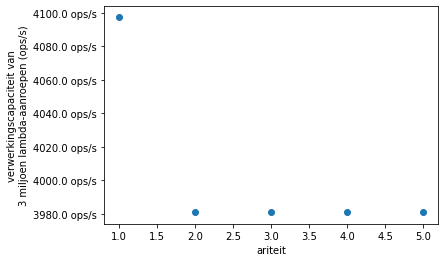

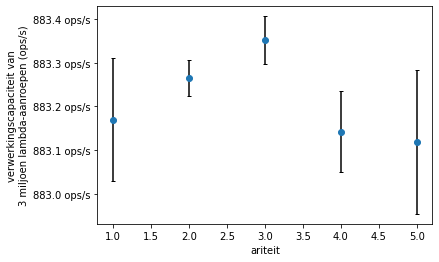

In [90]:
plot_performance_results(query="arity_test and invocation_test and not instantiation_test and arity < 6", x_label="ariteit", y_label="verwerkingscapaciteit van\n3 miljoen lambda-aanroepen (ops/s)", base_file_name="individual-performance-benchmark-results-arity-1-5-call", x_column="arity", round_dec=2)

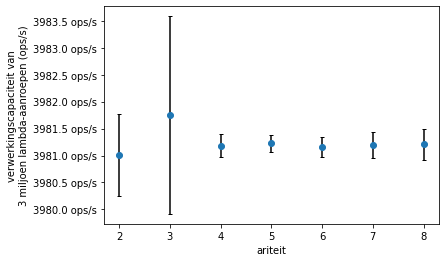

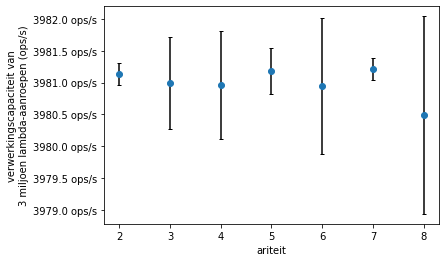

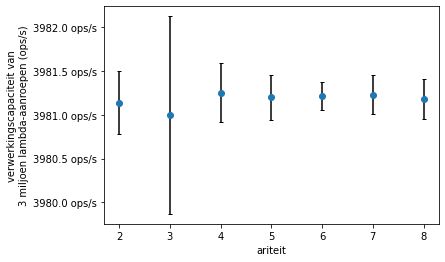

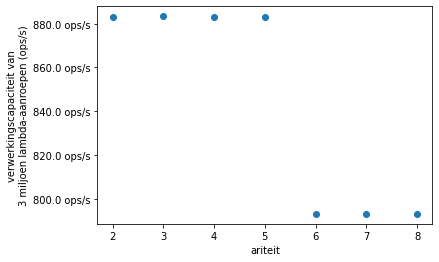

In [92]:
plot_performance_results(query="arity_test and invocation_test and not instantiation_test and arity >= 2 and arity <= 8", x_label="ariteit", y_label="verwerkingscapaciteit van\n3 miljoen lambda-aanroepen (ops/s)", base_file_name="individual-performance-benchmark-results-arity-2-8-call", x_column="arity", round_dec=2)

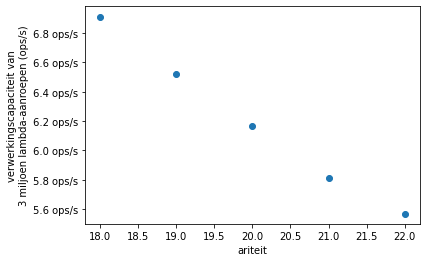

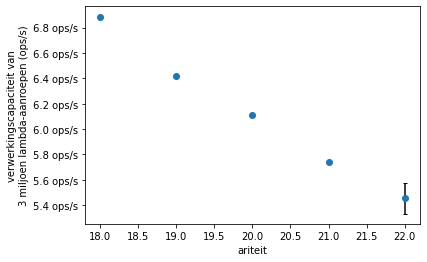

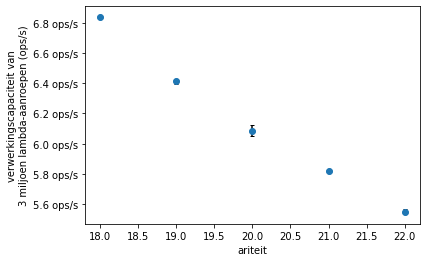

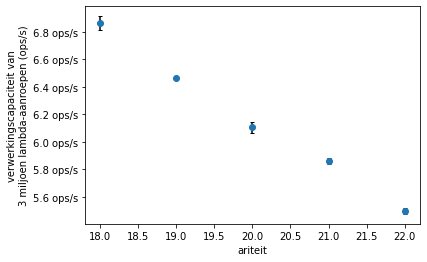

In [93]:
plot_performance_results(query="arity_test and invocation_test and not instantiation_test and arity >= 18 and arity <= 22", x_label="ariteit", y_label="verwerkingscapaciteit van\n3 miljoen lambda-aanroepen (ops/s)", base_file_name="individual-performance-benchmark-results-arity-18-22-call", x_column="arity", round_dec=2)

transformation
original                                    AxesSubplot(0.125,0.125;0.775x0.755)
pg_lambda_merging                           AxesSubplot(0.125,0.125;0.775x0.755)
pg_shrinking_lambda_merging_optimisation    AxesSubplot(0.125,0.125;0.775x0.755)
r8_shrinking_optimisation                   AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

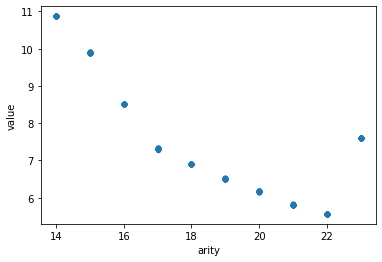

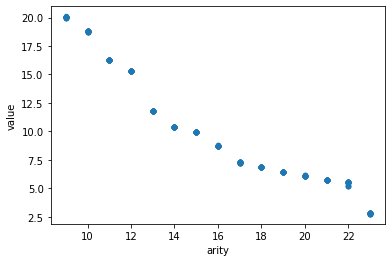

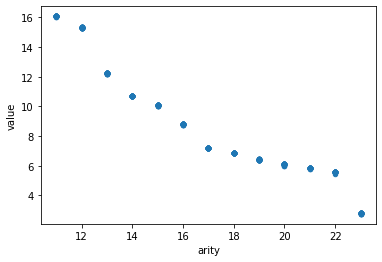

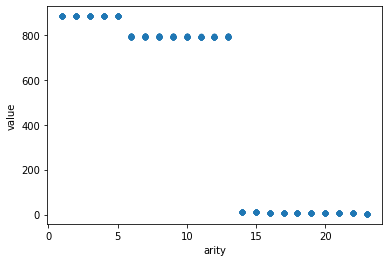

In [15]:
test_df.query("arity_test and invocation_test and not instantiation_test and value < 3000").groupby(by="transformation").plot.scatter(x="arity", y="value")

transformation
original                                    AxesSubplot(0.125,0.125;0.775x0.755)
pg_lambda_merging                           AxesSubplot(0.125,0.125;0.775x0.755)
pg_shrinking_lambda_merging_optimisation    AxesSubplot(0.125,0.125;0.775x0.755)
r8_shrinking_optimisation                   AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

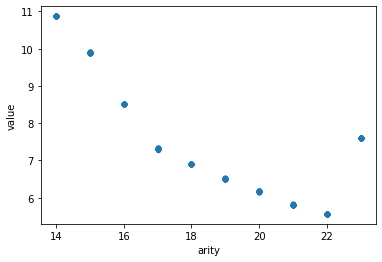

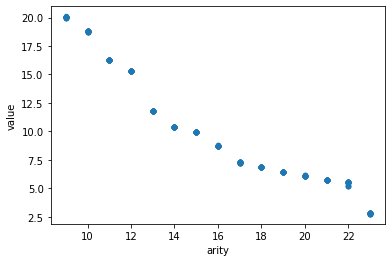

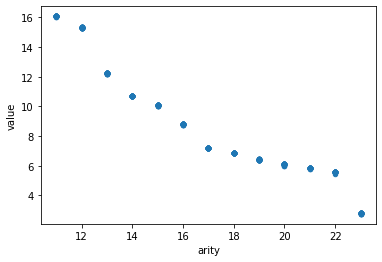

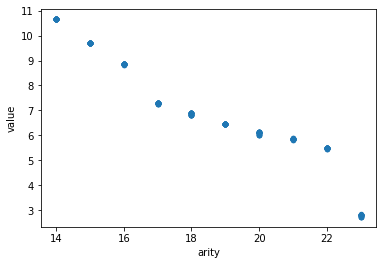

In [16]:
test_df.query("arity_test and invocation_test and not instantiation_test and value < 100").groupby(by="transformation").plot.scatter(x="arity", y="value")

In [17]:
test_df.query("closure_test and not invocation_test and instantiation_test").groupby(by="transformation").plot.scatter(x="closure_size", y="value")

""
transformation
